In [67]:
import warnings
from tqdm.notebook import tqdm
import itertools
from collections import deque

import pandas as pd

from edgedroid.models import *
from edgedroid.models.sampling.adaptive import _aperiodic_instant_iterator
import numpy as np
from typing import Callable, Dict, NamedTuple, Tuple
import abc
import multiprocess as mp
import scipy.stats as stats
from sampling_util import *

reference_name = "Moothedath et. al. 2022\nED2 estimator"

def experimental_run(
        rtt: float,
        proc_t: float,
        P0: float,
        Pc: float,
        task_steps: int,
        repetition: int,
):
    tc = rtt - proc_t
    calc_energy = lambda result: calculate_energy(P0, Pc, tc, result)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ground_truth = ExpKernelRollingTTFETModel(neuroticism=1.0)
        samplers: Dict[str, Sampler] = {
            "Greedy": GreedySampler(),
            "Wang et. al. 2019\nGaussian fit": JunjuesSampler(
                cdf=FittedNaiveExecutionTimeModel(dist=stats.norm).get_cdf_at_instant,
                min_sr=0.5,
                alpha=3.0,
            ),
            reference_name: OptimumSampler(
                mean_exec_time_estimator=ExpKernelRollingTTFETModel(neuroticism=1).get_mean_execution_time,
                alpha_calculator=lambda : tc * (Pc - P0),
                beta_calculator=lambda : P0
            ),
            "Ideal": IdealSampler(),
        }

    rows = deque()

    for name, sampler in samplers.items():
        ground_truth.reset()
        prev_ttf = rtt

        for step in range(1, task_steps + 1):
            exec_time = ground_truth.advance(prev_ttf).get_execution_time()
            sampling_result = sampler(exec_time, rtt)
            energy = calc_energy(sampling_result)

            ttf = sampling_result.duration - exec_time
            wait_time = ttf - rtt

            rows.append({
                "sampler": name,
                "rtt": rtt,
                "proc_time": proc_t,
                "P0": P0,
                "Pc": Pc,
                "repetition": repetition,
                "step": step,
                "exec_time": exec_time,
                "duration": sampling_result.duration,
                "ttf": ttf,
                "wait_time": wait_time,
                "energy": energy,
                "num_samples": sampling_result.num_samples,
            })

            prev_ttf = ttf

    df = pd.DataFrame(rows)
    df["sampler"] = df["sampler"].astype(pd.CategoricalDtype(samplers.keys(), ordered=False))
    return df


processing_delay = 0.3
rtts = np.array([0.3375, 0.675, 1.25, 2.5, 5.0])

task_steps = 100
repetitions = 100

P0 = 0.015
Pc = 0.045

combinations = list(itertools.product(
    rtts,
    # [processing_delay],
    # [P0],
    # [Pc],
    # [task_steps],
    range(1, repetitions + 1)
))

results = deque()

with tqdm(total=len(combinations)) as bar, mp.Pool() as pool:
    def _callback(df: pd.DataFrame):
        results.append(df)
        bar.update()

    def _errback(error):
        print(error)
        raise error

    for rtt, rep in combinations:
        pool.apply_async(
            experimental_run,
            args=(rtt, processing_delay, P0, Pc, task_steps, rep),
            callback=_callback,
            error_callback=_errback,
        )

    pool.close()
    pool.join()

results = pd.concat(results, ignore_index=True)
results

  0%|          | 0/500 [00:00<?, ?it/s]

,sampler,rtt,proc_time,P0,Pc,repetition,step,exec_time,duration,ttf,wait_time,energy,num_samples
0,Greedy,0.3375,0.3,0.015,0.045,3,1,2.508336,3.037500,0.529164,1.916641e-01,0.055688,9
1,Greedy,0.3375,0.3,0.015,0.045,3,2,3.372536,3.712500,0.339964,2.464409e-03,0.068062,11
2,Greedy,0.3375,0.3,0.015,0.045,3,3,11.890658,12.487500,0.596842,2.593425e-01,0.228938,37
3,Greedy,0.3375,0.3,0.015,0.045,3,4,3.484645,4.050000,0.565355,2.278551e-01,0.074250,12
4,Greedy,0.3375,0.3,0.015,0.045,3,5,4.800089,5.400000,0.599911,2.624108e-01,0.099000,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,Ideal,5.0000,0.3,0.015,0.045,100,96,9.146044,14.146044,5.000000,0.000000e+00,0.353191,1
199996,Ideal,5.0000,0.3,0.015,0.045,100,97,7.557365,12.557365,5.000000,-8.881784e-16,0.329360,1
199997,Ideal,5.0000,0.3,0.015,0.045,100,98,8.360474,13.360474,5.000000,0.000000e+00,0.341407,1
199998,Ideal,5.0000,0.3,0.015,0.045,100,99,8.024428,13.024428,5.000000,0.000000e+00,0.336366,1


In [68]:
mean_energy_per_step = (
    results
    .groupby(["sampler", "rtt", "repetition"])
    ["energy"]
    .mean()
    # .groupby(["sampler", "rtt"])
    # .mean()
)

mean_energy_per_step

sampler  rtt     repetition
Greedy   0.3375  1             0.101970
                 2             0.111313
                 3             0.105992
                 4             0.101970
                 5             0.107168
                                 ...   
Ideal    5.0000  96            0.316349
                 97            0.334247
                 98            0.328900
                 99            0.322422
                 100           0.314965
Name: energy, Length: 2000, dtype: float64

In [69]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)
sns.set_palette("Dark2")

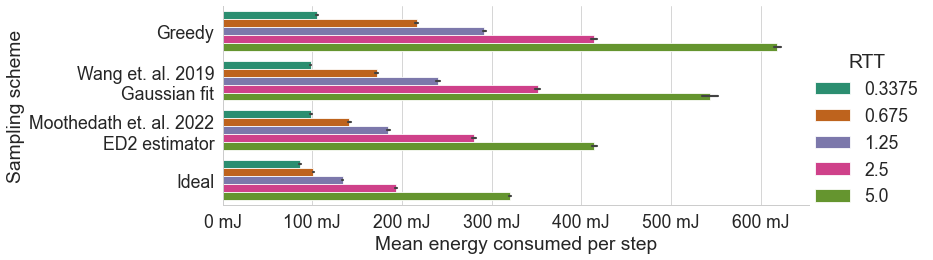

In [74]:
plot_data = mean_energy_per_step.reset_index()
# plot_data["rtt"] = plot_data["rtt"].apply(lambda s: f"{s:0.3f} s")

height = 4

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    x="energy",
    y="sampler",
    hue="rtt",
    aspect=12 / height,
    height=height,
    # legend_out=False,
)
fg.set_axis_labels("Mean energy consumed per step", "Sampling scheme")
fg.legend.set_title("RTT")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x * 1000:1.0f} mJ"))
plt.show()

# TODO: remove Wang, estimator, Moothedath original

In [71]:
import pingouin as pg

ix = pd.IndexSlice


def diff_wrt_ref_rtt(df: pd.DataFrame) -> pd.DataFrame:
    ref_energy = df.loc[df["sampler"] == reference_name, "energy"].to_numpy()
    ref_mean = ref_energy.mean()

    def diff_wrt_ref(samples: pd.Series) -> pd.Series:
        ttest = pg.ttest(samples.to_numpy(), ref_energy, alternative="two-sided")
        diff_raw = samples.mean() - ref_mean
        diff = diff_raw / ref_mean
        ci = ttest.at["T-test", "CI95%"]

        pval = ttest.at["T-test", "p-val"]
        sig_pval = pval < 0.05

        return pd.Series({
            "diff"     : diff,
            "diff_raw" : diff_raw,
            "p-val"    : pval,
            "p < 0.05" : sig_pval,
            "CI95_Low" : ci[0] / ref_mean,
            "CI95_High": ci[1] / ref_mean}, name="Result")

    return df.groupby("sampler")["energy"].apply(diff_wrt_ref)


energy_diff = mean_energy_per_step.reset_index().groupby(["rtt"]).apply(diff_wrt_ref_rtt).stack().stack().unstack(level=1).reset_index()
energy_diff = energy_diff[energy_diff["sampler"] != reference_name]
energy_diff["sampler"] = energy_diff["sampler"].cat.remove_unused_categories()
energy_diff

,rtt,sampler,diff,diff_raw,p-val,p < 0.05,CI95_Low,CI95_High
0,0.3375,Greedy,0.066052,0.006529,0.0,True,0.101161,0.101161
1,0.3375,Wang et. al. 2019\nGaussian fit,-0.006712,-0.000664,0.238184,False,-0.0,0.0
3,0.3375,Ideal,-0.12665,-0.01252,0.0,True,-0.101161,-0.101161
4,0.6750,Greedy,0.529074,0.074877,0.0,True,0.494616,0.565275
5,0.6750,Wang et. al. 2019\nGaussian fit,0.213495,0.030215,0.0,True,0.211978,0.211978
7,0.6750,Ideal,-0.284862,-0.040315,0.0,True,-0.282638,-0.282638
8,1.2500,Greedy,0.57753,0.106866,0.0,True,0.540424,0.594467
9,1.2500,Wang et. al. 2019\nGaussian fit,0.296375,0.054841,0.0,True,0.270212,0.324255
11,1.2500,Ideal,-0.275975,-0.051066,0.0,True,-0.270212,-0.270212
12,2.5000,Greedy,0.476164,0.13365,0.0,True,0.463159,0.498787


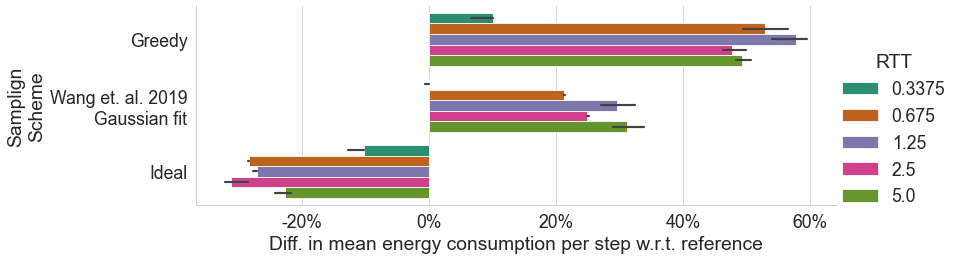

In [73]:
import matplotlib.ticker as tkr

plot_data = energy_diff.set_index(["sampler", "rtt"])[["CI95_Low", "CI95_High", "diff"]].stack().reset_index().rename(columns={0: "values"})

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    estimator=lambda e: sorted(e)[1],
    errorbar=lambda e: (min(e), max(e)),
    y="sampler",
    hue="rtt",
    x="values",
    aspect=12 / height,
    height=height,
)
fg.legend.set_title("RTT")
fg.set_axis_labels("Diff. in mean energy consumption per step w.r.t. reference", "Samplign\nScheme")
# fg.set(xticks=np.linspace(-0.25, 0, 6))
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:0.0%}" if x != 0.0 else "0%"))
plt.show()

In [5]:
mean_samples_per_step = (
    results
    .groupby(["sampler", "rtt", "repetition"])
    ["num_samples"]
    .mean()
    # .groupby(["sampler", "rtt"])
    # .mean()
)

mean_samples_per_step

sampler                            rtt     repetition
Greedy                             0.3375  1             17.36
                                           2             17.36
                                           3             17.24
                                           4             16.70
                                           5             17.09
                                                         ...  
Moothedath et. al., ED2 estimator  5.0000  96             1.34
                                           97             1.32
                                           98             1.40
                                           99             1.25
                                           100            1.21
Name: num_samples, Length: 2000, dtype: float64

In [6]:
mean_samples_per_step.groupby(["sampler", "rtt"]).mean()

sampler                            rtt   
Greedy                             0.3375    17.1602
                                   0.6750    10.0232
                                   1.2500     6.1998
                                   2.5000     3.9898
                                   5.0000     2.8873
Ideal                              0.3375     1.0000
                                   0.6750     1.0000
                                   1.2500     1.0000
                                   2.5000     1.0000
                                   5.0000     1.0000
Wang et. al., gaussian fit         0.3375     9.6375
                                   0.6750     6.3307
                                   1.2500     4.3321
                                   2.5000     2.9564
                                   5.0000     2.1922
Moothedath et. al., ED2 estimator  0.3375     5.9520
                                   0.6750     2.4711
                                   1.2500     1.7978
    

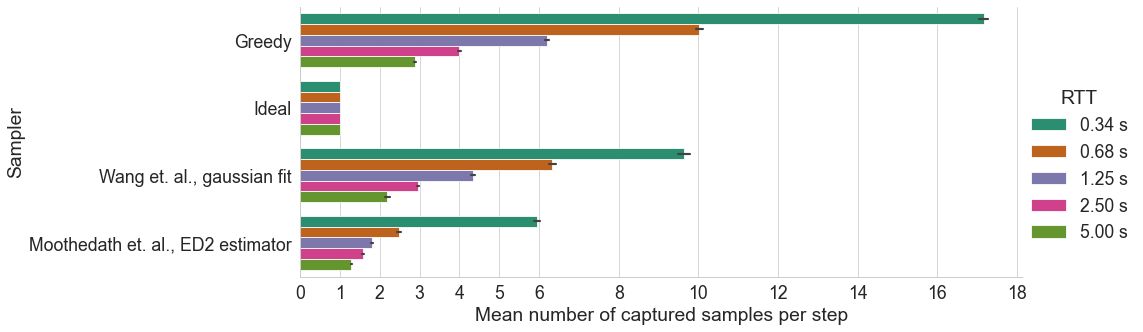

In [7]:
plot_data = mean_samples_per_step.reset_index()
plot_data["rtt"] = plot_data["rtt"].apply(lambda s: f"{s:0.2f} s")

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    x="num_samples",
    y="sampler",
    hue="rtt",
    aspect=3,
)
fg.set_axis_labels("Mean number of captured samples per step", "Sampler")
fg.set(xticks=list(np.linspace(0, 5, 6)) + list(np.linspace(6.0, 18.0, 7)))
fg.legend.set_title("RTT")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:0.0f}"))
plt.show()

In [8]:
mean_wait_per_step = (
    results
    .groupby(["sampler", "rtt", "repetition"])
    ["wait_time"]
    .mean()
    # .groupby(["sampler", "rtt"])
    # .mean()
)

mean_wait_per_step

sampler                            rtt     repetition
Greedy                             0.3375  1             0.180152
                                           2             0.168644
                                           3             0.174700
                                           4             0.194617
                                           5             0.176634
                                                           ...   
Moothedath et. al., ED2 estimator  5.0000  96            3.649892
                                           97            3.587217
                                           98            3.554465
                                           99            3.512515
                                           100           3.621886
Name: wait_time, Length: 2000, dtype: float64

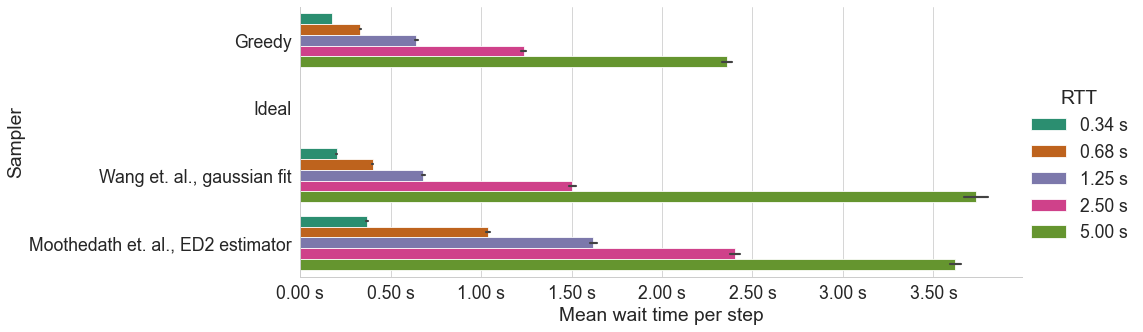

In [9]:
plot_data = mean_wait_per_step.reset_index()
plot_data["rtt"] = plot_data["rtt"].apply(lambda s: f"{s:0.2f} s")

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    x="wait_time",
    y="sampler",
    hue="rtt",
    aspect=3,
)
fg.set_axis_labels("Mean wait time per step", "Sampler")
# fg.set(xticks=list(np.linspace(0, 5, 6)) + list(np.linspace(6.0, 18.0, 7)))
fg.legend.set_title("RTT")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:0.2f} s"))
plt.show()

# push rtts up
# means that account for energy in idle or comm is more important than distributions
# super neurotic user

In [18]:
class SuperNeuroticModel(ExpKernelRollingTTFETModel):
    @staticmethod
    def get_data() -> Tuple[
        pd.DataFrame,
        pd.arrays.IntervalArray,
        pd.arrays.IntervalArray,
        pd.arrays.IntervalArray,
    ]:

        scaling_factor_min: float = 0.25
        scaling_factor_max: float = 4

        data, *r = ExpKernelRollingTTFETModel.get_data()
        # print(data)

        old_min = data["exec_time"].min()
        old_max = data["exec_time"].max()

        new_min = old_min * scaling_factor_min
        new_max = old_max * scaling_factor_max
        new_range = new_max - new_min

        data["exec_time"] = (data["exec_time"] - old_min) / (old_max - old_min)
        data["exec_time"] = (data["exec_time"] * new_range) + new_min

        return data, *r


def superneurotic_experimental_run(
        rtt: float,
        proc_t: float,
        P0: float,
        Pc: float,
        task_steps: int,
        repetition: int,
):
    tc = rtt - proc_t
    calc_energy = lambda result: calculate_energy(P0, Pc, tc, result)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ground_truth = SuperNeuroticModel(neuroticism=1.0)
        samplers: Dict[str, Sampler] = {
            "Greedy": GreedySampler(),
            "Ideal": IdealSampler(),
            "Moothedath, original": OptimumSampler(
                mean_exec_time_estimator=FittedNaiveExecutionTimeModel(dist=stats.rayleigh).get_mean_execution_time,
                alpha_calculator=lambda : tc * (Pc - P0),
                beta_calculator=lambda : P0
            ),
            "Moothedath et. al., superneurotic estimator": OptimumSampler(
                mean_exec_time_estimator=SuperNeuroticModel(neuroticism=1).get_mean_execution_time,
                alpha_calculator=lambda : tc * (Pc - P0),
                beta_calculator=lambda : P0
            )
        }

    rows = deque()

    for name, sampler in samplers.items():
        ground_truth.reset()
        prev_ttf = rtt

        for step in range(1, task_steps + 1):
            exec_time = ground_truth.advance(prev_ttf).get_execution_time()
            sampling_result = sampler(exec_time, rtt)
            energy = calc_energy(sampling_result)

            ttf = sampling_result.duration - exec_time
            wait_time = ttf - rtt

            rows.append({
                "sampler": name,
                "rtt": rtt,
                "proc_time": proc_t,
                "P0": P0,
                "Pc": Pc,
                "repetition": repetition,
                "step": step,
                "exec_time": exec_time,
                "duration": sampling_result.duration,
                "ttf": ttf,
                "wait_time": wait_time,
                "energy": energy,
                "num_samples": sampling_result.num_samples,
            })

            prev_ttf = ttf

    df = pd.DataFrame(rows)
    df["sampler"] = df["sampler"].astype(pd.CategoricalDtype(samplers.keys(), ordered=False))
    return df



processing_delay = 0.15
rtts = np.array([0.2, 0.4, 0.8, 1.6, 3.2, 6.4])

task_steps = 100
repetitions = 100

P0 = 0.015
Pc = 0.045

combinations = list(itertools.product(
    rtts,
    # [processing_delay],
    # [P0],
    # [Pc],
    # [task_steps],
    range(1, repetitions + 1)
))

results = deque()

with tqdm(total=len(combinations)) as bar, mp.Pool() as pool:
    def _callback(df: pd.DataFrame):
        results.append(df)
        bar.update()

    def _errback(error):
        print(error)
        raise error

    for rtt, rep in combinations:
        pool.apply_async(
            superneurotic_experimental_run,
            args=(rtt, processing_delay, P0, Pc, task_steps, rep),
            callback=_callback,
            error_callback=_errback,
        )

    pool.close()
    pool.join()

results = pd.concat(results, ignore_index=True)
results

  0%|          | 0/600 [00:00<?, ?it/s]

,sampler,rtt,proc_time,P0,Pc,repetition,step,exec_time,duration,ttf,wait_time,energy,num_samples
0,Greedy,0.2,0.15,0.015,0.045,2,1,9.816176,10.200000,0.383824,0.183824,0.229500,51
1,Greedy,0.2,0.15,0.015,0.045,2,2,19.728924,20.000000,0.271076,0.071076,0.450000,100
2,Greedy,0.2,0.15,0.015,0.045,2,3,10.959992,11.200000,0.240008,0.040008,0.252000,56
3,Greedy,0.2,0.15,0.015,0.045,2,4,23.806961,24.200000,0.393039,0.193039,0.544500,121
4,Greedy,0.2,0.15,0.015,0.045,2,5,12.866625,13.200000,0.333375,0.133375,0.297000,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,"Moothedath et. al., superneurotic estimator",6.4,0.15,0.015,0.045,96,96,18.242703,31.612752,13.370049,6.970049,0.661691,1
239996,"Moothedath et. al., superneurotic estimator",6.4,0.15,0.015,0.045,96,97,29.979793,46.422749,16.442956,10.042956,1.071341,2
239997,"Moothedath et. al., superneurotic estimator",6.4,0.15,0.015,0.045,96,98,20.600562,31.612752,11.012190,4.612190,0.661691,1
239998,"Moothedath et. al., superneurotic estimator",6.4,0.15,0.015,0.045,96,99,24.268892,31.612752,7.343860,0.943860,0.661691,1


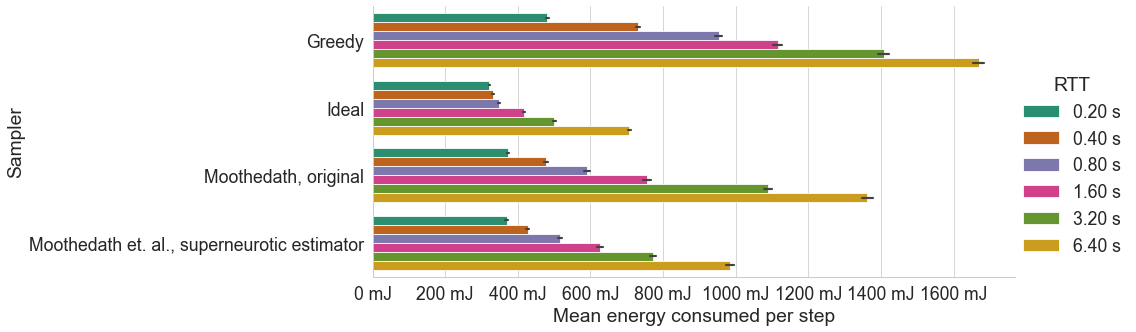

sampler                                      rtt  repetition
Greedy                                       0.2  1             0.444600
                                                  2             0.449280
                                                  3             0.444465
                                                  4             0.473490
                                                  5             0.488160
                                                                  ...   
Moothedath et. al., superneurotic estimator  6.4  96            1.017073
                                                  97            0.963339
                                                  98            0.955571
                                                  99            0.968348
                                                  100           0.871285
Name: energy, Length: 2400, dtype: float64

In [19]:
mean_energy_per_step = (
    results
    .groupby(["sampler", "rtt", "repetition"])
    ["energy"]
    .mean()
    # .groupby(["sampler", "rtt"])
    # .mean()
)

plot_data = mean_energy_per_step.reset_index()
plot_data["rtt"] = plot_data["rtt"].apply(lambda s: f"{s:0.2f} s")

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    x="energy",
    y="sampler",
    hue="rtt",
    aspect=3,
)
fg.set_axis_labels("Mean energy consumed per step", "Sampler")
fg.legend.set_title("RTT")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x * 1000:1.0f} mJ"))
plt.show()

mean_energy_per_step